In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss,ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error,mean_absolute_error
from numpy.linalg import norm
from scipy.spatial.distance import cityblock,minkowski
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
!pip install xgboost
import xgboost as xgb
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# 1.a Data Exploration
> Let's observe the raw data and concatinate the relavent columns to create a train data and test data

In [94]:
train = pd.read_csv('train.csv', encoding = "ISO-8859-1")
product_descriptions = pd.read_csv('product_descriptions.csv', encoding = "ISO-8859-1")
test = pd.read_csv('test.csv', encoding = "ISO-8859-1")
solution = pd.read_csv('solution.csv', encoding = "ISO-8859-1")

In [95]:
train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [96]:
product_descriptions.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [97]:
len(product_descriptions)

124428

In [98]:
test.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


In [99]:
solution.head()

,id,relevance,Usage
0,1,-1.00,Ignored
1,4,2.33,Public
2,5,2.33,Private
3,6,2.67,Private
4,7,2.00,Public


In [100]:
train = pd.merge(train, product_descriptions, on=["product_uid", "product_uid"])
train.insert(3, 'product_description', train.pop('product_description'))

In [101]:
train.head()

,id,product_uid,product_title,product_description,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,BEHR Premium Textured DECKOVER is an innovativ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,Update your bathroom with the Delta Vero Singl...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,Update your bathroom with the Delta Vero Singl...,shower only faucet,2.67


In [102]:
test = pd.merge(test, product_descriptions, on=["product_uid", "product_uid"])
test.insert(3, 'product_description', test.pop('product_description'))
test = pd.merge(test, solution, on=["id", "id"])

In [103]:
test.head()

,id,product_uid,product_title,product_description,search_term,relevance,Usage
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",90 degree bracket,-1.00,Ignored
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",metal l brackets,2.33,Public
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",simpson sku able,2.33,Private
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",simpson strong ties,2.67,Private
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",simpson strong tie hcc668,2.00,Public


In [104]:
test = test.drop(test[test.Usage == 'Ignored'].index)

In [105]:
test.head()

,id,product_uid,product_title,product_description,search_term,relevance,Usage
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",metal l brackets,2.33,Public
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",simpson sku able,2.33,Private
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",simpson strong ties,2.67,Private
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",simpson strong tie hcc668,2.00,Public
6,10,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,Classic architecture meets contemporary design...,bath and shower kit,2.67,Private


now that we see the data is properly merged and the index count is valid we can save the final train and test data without the index columns.

In [106]:
train.to_csv('train_data.csv', index=False)
test.to_csv('test_data.csv', index=False)

In [107]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [108]:
train_data.head()

,id,product_uid,product_title,product_description,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,BEHR Premium Textured DECKOVER is an innovativ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,Update your bathroom with the Delta Vero Singl...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,Update your bathroom with the Delta Vero Singl...,shower only faucet,2.67


lets explore the training and test data

In [109]:
print('train data length: ' + str(len(train_data)))
print('test data length: ' + str(len(test_data)))

train data length: 74067
test data length: 112067


In [110]:
train_data.iloc[2]

id                                                                     9
product_uid                                                       100002
product_title          BEHR Premium Textured DeckOver 1-gal. #SC-141 ...
product_description    BEHR Premium Textured DECKOVER is an innovativ...
search_term                                                    deck over
relevance                                                            3.0
Name: 2, dtype: object

In [111]:
print('Average character length in description:')
train_data['product_description'].apply(len).mean()

Average character length in description:


885.663750388162

In [112]:
print('Average word length in description:')
train_data['product_description'].apply(str).apply(lambda x: x.split()).apply(len).mean()

Average word length in description:


133.72566730122728

In [113]:
train_data.iloc[1]['product_description'][:100]

'Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpso'

In [114]:
train_data['relevance'].mean()

2.381633791027016

In [115]:
train_data['relevance'].value_counts()

3.00    19125
2.33    16060
2.67    15202
2.00    11730
1.67     6780
1.33     3006
1.00     2105
2.50       19
2.75       11
2.25       11
1.75        9
1.50        5
1.25        4
Name: relevance, dtype: int64

<AxesSubplot:xlabel='relevance', ylabel='Count'>

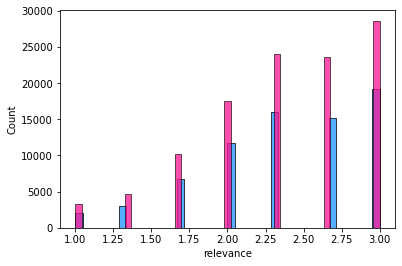

In [116]:
import seaborn as sns
sns.histplot(train_data['relevance'], color="dodgerblue")
sns.histplot(test_data['relevance'], color="deeppink")

## train validation split

In [117]:
train_df,val_df = train_test_split(train_data, test_size=0.2)

In [118]:
train_df = train_df.reset_index(drop=True)

In [119]:
val_df= val_df.reset_index(drop=True)

In [120]:
train_df

,id,product_uid,product_title,product_description,search_term,relevance
0,192065,183040,George Foreman Indoor/Outdoor Electric Grill,Versatility is in the name. Easy conversion fr...,outdoor baba grill,2.00
1,365,100060,RDI Porch and Newel 5 in. x 5 in. x 108 in. Vi...,Add elegance and sophistication to any porch o...,post,2.33
2,97877,130529,Builders Edge 15 in. x 67 in. Raised Panel Vin...,Builders Edge decorative 15 in. x 67 in. Raise...,shutter exterior movable,2.33
3,94513,129147,Classic Accessories Veranda 78 in. Patio Day C...,The Veranda collection combines style and func...,chaise,2.67
4,94196,129019,Edsal 48 in. W x 30 in. D Workbench with Storage,Make a valuable and practical addition to your...,edsal workbench,3.00
...,...,...,...,...,...,...
59248,126561,143714,BOEN 4 in. x 4 in. Wall Repair Patch,FiflexMesh Wall repair patch is another DIY it...,repair patch,3.00
59249,137043,149033,1/2 in. x 2 ft. x 4 ft. PureBond Maple Plywood...,PureBond plywood project panels are a convenie...,maple lumber,2.67
59250,7637,101291,Cub Cadet XT1 Enduro Series GT 50 in. 25 HP V-...,The Cub Cadet XT1 50 in. riding garden tractor...,lawn tractor,3.00
59251,135375,148165,Philips 60W Equivalent Daylight A19 LED Light ...,Philips LED A-shape light bulbs are a smart al...,phillits,2.67


In [121]:
val_df

,id,product_uid,product_title,product_description,search_term,relevance
0,179574,174227,Speedi-Products 4 in. Aluminum Flush Roof Cap ...,Speedi-Products 4 in. Aluminum flush roof cap ...,4 pvc vent screen,2.67
1,152833,157675,Lutron Credenza 300-Watt Plug-In Lamp Dimmer -...,Use the Lutron Credenza 300-Watt Lamp Dimmer t...,credenza,3.00
2,47956,112033,Ohio Steel Professional Grade 42 in. 18 cu. ft...,This Professional Grade Lawn Sweeper features ...,lawn sweepers,3.00
3,15457,102717,ClosetMaid 73-1/4 in. H x 32 in. W x 18-3/4 in...,The ClosetMaid 32 in. Garage Cabinet has a dur...,door knob self locking,2.00
4,23799,104691,Ryobi ONE+ 18-Volt Lithium-Ion Ultimate Combo ...,Seldom has a comprehensive cordless tool kit b...,porter-cable 4-tool 18-volt nickel cordless,2.67
...,...,...,...,...,...,...
14809,147322,154564,Feit Electric 100W Equivalent Blue PAR38 CFL F...,This product is a 12 pack of 20 Watt Par38 col...,par38 cfl,2.67
14810,147731,154779,Speedi-Products 3 in. Plastic Wide Mouth Exhau...,Speedi-Products 3 in. White plastic wide mouth...,kitchen wall plastic vent,2.33
14811,172993,169857,VELUX 4 - 6 ft. Telescoping 7-Hook Control Rod...,The ZXT 200 control rod is used to operate out...,skylight opening rods,2.33
14812,155641,159278,Milwaukee Black Oxide Drill Bit Set (14-Piece),The Milwaukee 48-89-2800 (14-Piece) Black Oxid...,milwaukee drill bits,3.00


## Dictionary with results

In [122]:
simaese_char = []
naive_benchmark = []
char_feature_extractor_KNN = []
char_feature_extractor_XGB = []
simaese_word = []
word_feature_extractor_KNN = []
word_feature_extractor_XGB = []

## 1.b Character Level LSTM

### Character sequences

In [123]:
characters = set()
product_ids = set()


for index, row in train_df.iterrows():
    if row['product_uid'] not in product_ids:
        for char in row['product_description'].lower():
            characters.add(char)
        for char in row['search_term'].lower():
            characters.add(char)
    for char in row['product_title'].lower():
        characters.add(char)
        
        

for index, row in val_df.iterrows():
    if row['product_uid'] not in product_ids:
        for char in row['product_description'].lower():
            characters.add(char)
        for char in row['search_term'].lower():
            characters.add(char)
    for char in row['product_title'].lower():
        characters.add(char)
        
for index, row in test_data.iterrows():
    if row['product_uid'] not in product_ids:
        for char in row['product_description'].lower():
            characters.add(char)
        for char in row['search_term'].lower():
            characters.add(char)
    for char in row['product_title'].lower():
        characters.add(char)


In [124]:
import string
alpha_dict = dict()

for i, char in enumerate(string.ascii_lowercase):
    alpha_dict[char] = i + 1

for i, char in enumerate(sorted(characters)):
    if char not in alpha_dict:
        alpha_dict[char] = i + 27

In [125]:
print(alpha_dict)
print(len(alpha_dict))

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, ' ': 27, '!': 28, '"': 29, '#': 30, '$': 31, '%': 32, '&': 33, "'": 34, '(': 35, ')': 36, '*': 37, '+': 38, ',': 39, '-': 40, '.': 41, '/': 42, '0': 43, '1': 44, '2': 45, '3': 46, '4': 47, '5': 48, '6': 49, '7': 50, '8': 51, '9': 52, ':': 53, ';': 54, '<': 55, '=': 56, '>': 57, '?': 58, '@': 59, '[': 60, '\\': 61, ']': 62, '^': 63, '_': 64, '`': 65, '{': 92, '}': 93, '~': 94, '\x81': 95, '\x89': 96, '\x90': 97, '\x95': 98, '\x9d': 99, '¡': 100, '¢': 101, 'ª': 102, 'à': 103, 'ã': 104, 'å': 105, 'è': 106, 'ê': 107, 'ï': 108, 'ò': 109, '÷': 110, 'û': 111, 'ü': 112}
86


### Dataset

In [126]:
class Character_dataset(Dataset):    
    def __init__(self, data, alpha_dict):
        self.data = data
        self.alpha_dict = alpha_dict
        self.stop = set(stopwords.words('english') + list(string.punctuation))
        self.ps = PorterStemmer()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        X = self.data.iloc[idx]
        Y = X['relevance'] - 2
        description = list(self.clean_text(X['product_description']))[:100]
        search = list(self.clean_text(X['search_term']))[:100]
        
        description = list(map(lambda x: alpha_dict[x], description))
        search = list(map(lambda x:  alpha_dict[x], search))
        
        padded_description = [0] * 100
        rand_index = random.randint(0, (100 - len(description)))
        padded_description[rand_index : rand_index + len(description)] = description
                        
        padded_search = [0] * 100
        rand_index = random.randint(0, (100 - len(search)))
        padded_search[rand_index : rand_index + len(search)] = search

        padded_description = torch.tensor(padded_description).reshape([100,1])
        padded_search = torch.tensor(padded_search).reshape([100,1])
        
        return padded_description, padded_search, torch.tensor([Y])
    
    
    def clean_text(self, text):
        res = ""
        for i in word_tokenize(text.lower()):
            if i not in self.stop:
                res += (self.ps.stem(i))
                           
        return res

In [127]:
train_dataset = Character_dataset(train_df, alpha_dict)

In [128]:
val_dataset = Character_dataset(val_df, alpha_dict)

In [129]:
len(train_dataset)

59253

### Siamese network from paper

In [130]:
class LSTM_Character_Model(nn.Module):
    def __init__(self, dim_input=1, n_hidden=64, n_layer=4):
        super(LSTM_Character_Model, self).__init__()
        
        self.similarity = nn.CosineSimilarity(dim=1)
        
        self.lstm  = nn.LSTM(
            batch_first=True,
            bidirectional = True,
            dropout=0.2,
            input_size = dim_input,
            hidden_size = n_hidden,
            num_layers = n_layer
        )
        
        self.fc1 = nn.Linear(128, 128)
                
    def forward(self, description, search):

        self.lstm.flatten_parameters()
        
        output_description, (hidden_description, cell_description) = self.lstm(description)
            
        output_search, (hidden_search, cell_search) = self.lstm(search)
        
        output_description = torch.mean(output_description, 1)

        output_search = torch.mean(output_search, 1)

        output_description = self.fc1(output_description)
        
        output_search = self.fc1(output_search)

        
        sim = self.similarity(output_description, output_search)

        sim = sim.reshape([len(output_search),1])

        return sim
        

In [131]:
lstm_character_model = LSTM_Character_Model().to(device)
lstm_character_model

LSTM_Character_Model(
  (similarity): CosineSimilarity()
  (lstm): LSTM(1, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
)

In [132]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [133]:
class SiameseLoss(nn.Module):
    def __init__(self):
        super(SiameseLoss, self).__init__()
        self.loss_func = nn.MSELoss(nn.MSELoss(reduction='none'))
        
    def forward(self, x, y):
        loss = self.loss_func(x,y)
        intensifire = pow(1 + abs(y - 0.38), 2)
        return torch.mean(torch.mul(loss, intensifire)) 

## Training, Validation and Test loops

In [134]:
def train_loop(data_loader,model,device,loss_fn,optimizer,print_every_n=500):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss=0
    
    rmse_fn = RMSELoss()
    mae_fn = nn.L1Loss()
    rmse_loss = 0
    mae_loss = 0
    
    for batch,(description, search, y) in enumerate(data_loader):
        description = description.to(device, dtype=torch.float)
        search = search.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.float)
        pred = model(description, search)
        
        loss = loss_fn(pred,y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        rmse_loss += rmse_fn(pred,y).item()
        mae_loss += mae_fn(pred,y).item()
            
        if batch%print_every_n==0:
            loss, current = loss.item(), batch*len(description)
            print(f'loss={loss:.3f}, {current} samples / {size}')
        
    rmse_loss /= num_batches
    mae_loss /= num_batches
    train_loss /= num_batches
    return train_loss, rmse_loss, mae_loss


In [135]:
def val_loop(data_loader,model,device,loss_fn):
    model.eval()
    num_batches = len(data_loader)
    size=len(data_loader.dataset)
    test_loss=0
    
    rmse_fn = RMSELoss()
    mae_fn = nn.L1Loss()
    rmse_loss = 0
    mae_loss = 0
    
    with torch.no_grad():
        for batch,(description, search, y) in enumerate(data_loader):
            description = description.to(device, dtype=torch.float)
            search = search.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.float)
            pred = model(description, search)
            
            test_loss += loss_fn(pred,y).item()
            
            rmse_loss += rmse_fn(pred,y).item()
            mae_loss += mae_fn(pred,y).item()
            
    rmse_loss /= num_batches
    mae_loss /= num_batches
    test_loss /= num_batches
    
    return test_loss, rmse_loss, mae_loss

In [136]:
def test_loop(data_loader,model,device,loss_fn):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss=0

    rmse_fn = RMSELoss()
    mae_fn = nn.L1Loss()
    rmse_loss = 0
    mae_loss = 0
    
    with torch.no_grad():
        for batch,(description, search, y) in enumerate(data_loader):
            description = description.to(device, dtype=torch.float)
            search = search.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.float)
            pred = model(description, search)

            test_loss += loss_fn(pred,y).item()

            rmse_loss += rmse_fn(pred,y).item()
            mae_loss += mae_fn(pred,y).item()
            
    rmse_loss /= num_batches
    mae_loss /= num_batches
    test_loss /= num_batches

    return test_loss, rmse_loss, mae_loss

## Model Parameters and Data loaders

In [137]:
learning_rate = 0.0001
epochs = 15
batch_size = 32
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_character_model.parameters(),lr=learning_rate)

In [138]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True)

In [139]:
torch.cuda.empty_cache()

history = {'train_loss': [], 'val_loss': [], 'train_rmse':[],'val_rmse':[], 'train_mae':[],'val_mae':[]}
start_time = time.time()

for epoch in range(epochs):
    print(f'Starting epoch {epoch+1}')

    train_epoch_loss, train_rmse_loss, train_mae_loss = train_loop(train_loader,lstm_character_model,device,loss_fn,optimizer)

    val_loss, val_rmse_loss, val_mae_loss = val_loop(val_loader,lstm_character_model,device,loss_fn)

    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f}".format(epoch + 1,
                                                                          epochs,
                                                                          train_epoch_loss,
                                                                          val_loss))

    print("AVG Training rmse Loss:{:.3f} AVG Val rmse Loss:{:.3f}".format(train_rmse_loss,
                                                                      val_rmse_loss))

    print(" AVG Training mae Loss:{:.3f} AVG Val mae Loss:{:.3f}".format(train_mae_loss,
                                                                      val_mae_loss))

    history['train_loss'].append(train_epoch_loss.detach().cpu().numpy())
    history['val_loss'].append(val_loss)
    history['train_rmse'].append(train_rmse_loss)
    history['val_rmse'].append(val_rmse_loss)   
    history['train_mae'].append(train_mae_loss)
    history['val_mae'].append(val_mae_loss)  
        
    
history['total_time'] = time.time() - start_time

Starting epoch 1
loss=0.714, 0 samples / 59253
loss=0.234, 16000 samples / 59253
loss=0.324, 32000 samples / 59253
loss=0.443, 48000 samples / 59253
Epoch:1/15 AVG Training Loss:0.296 AVG Val Loss:0.288
AVG Training rmse Loss:0.540 AVG Val rmse Loss:0.533
 AVG Training mae Loss:0.447 AVG Val mae Loss:0.440
Starting epoch 2
loss=0.353, 0 samples / 59253
loss=0.296, 16000 samples / 59253
loss=0.231, 32000 samples / 59253
loss=0.257, 48000 samples / 59253
Epoch:2/15 AVG Training Loss:0.288 AVG Val Loss:0.285
AVG Training rmse Loss:0.534 AVG Val rmse Loss:0.531
 AVG Training mae Loss:0.440 AVG Val mae Loss:0.435
Starting epoch 3
loss=0.243, 0 samples / 59253
loss=0.269, 16000 samples / 59253
loss=0.349, 32000 samples / 59253
loss=0.289, 48000 samples / 59253
Epoch:3/15 AVG Training Loss:0.287 AVG Val Loss:0.287
AVG Training rmse Loss:0.532 AVG Val rmse Loss:0.532
 AVG Training mae Loss:0.439 AVG Val mae Loss:0.441
Starting epoch 4
loss=0.255, 0 samples / 59253
loss=0.211, 16000 samples / 5

## Plots

In [140]:
def plot_acc_loss(history):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].plot(history['train_loss'])
    ax[0].plot(history['val_loss'])
    ax[0].set_title('Model loss: ')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    ax[1].plot(history['train_rmse'])
    ax[1].plot(history['val_rmse'])
    ax[1].set_title('Model rmse loss: ')
    ax[1].set_ylabel('Rmse')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
    ax[2].plot(history['train_mae'])
    ax[2].plot(history['val_mae'])
    ax[2].set_title('Model mae loss: ')
    ax[2].set_ylabel('Mae')
    ax[2].set_xlabel('Epoch')
    ax[2].legend(['Train', 'Test'], loc='upper left')
    plt.show()

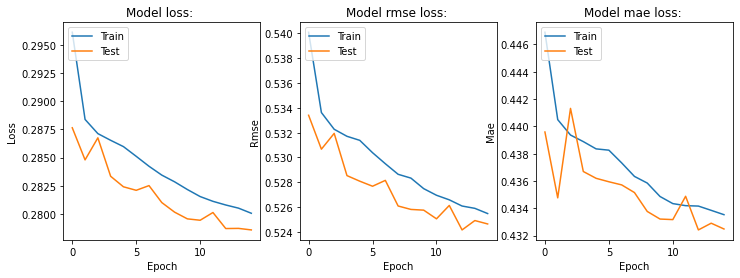

In [141]:
plot_acc_loss(history)

In [142]:
print(history['train_loss'][-1])
print(history['val_loss'][-1])
print(history['train_rmse'][-1])
print(history['val_rmse'][-1])
print(history['train_mae'][-1])
print(history['val_mae'][-1])

0.28006652
0.27859039577307504
0.5254790416031625
0.5246401816027211
0.4335320700064591
0.4324841960846219


## Testing

In [143]:
test_dataset = Character_dataset(test_data, alpha_dict)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)
test_loss, test_rmse_loss, test_mae_loss = test_loop(test_loader,lstm_character_model,device,loss_fn)
print("test loss : " + str(test_loss))
print("test rmse loss : " + str(test_rmse_loss))
print("test mae loss : " + str(test_mae_loss))

test loss : 0.28304089794890935
test rmse loss : 0.5282906397577357
test mae loss : 0.4353805627443094


In [144]:
torch.save(lstm_character_model, 'models/LSTM_Character_Model.pt')

In [145]:
simaese_char.append(history['total_time']/60)
simaese_char.append(history['train_rmse'][-1])
simaese_char.append(history['val_rmse'][-1])
simaese_char.append(test_rmse_loss)
simaese_char.append(history['train_mae'][-1])
simaese_char.append(history['val_mae'][-1])
simaese_char.append(test_mae_loss)

In [146]:
simaese_char

[53.93897269964218,
 0.5254790416031625,
 0.5246401816027211,
 0.5282906397577357,
 0.4335320700064591,
 0.4324841960846219,
 0.4353805627443094]

## 1.c Naive Benchmark

> for our benchmark we will create a vector with the frequencies of characters for the search term and Product description using CountVectorizer. Then for each row find the cosine similiratiy between these vectors and caculate our metrics

In [147]:
def benchmark_similiraties(df):
    descriptions = df['product_description'].apply(str.lower).values.tolist()
    searches = df['search_term'].apply(str.lower).values.tolist()
    char_vectorizer = CountVectorizer(analyzer='char', min_df=1)
    desc_count_array = char_vectorizer.fit_transform(descriptions).toarray()
    desc_df = pd.DataFrame(data=desc_count_array,columns = char_vectorizer.get_feature_names())
    search_count_array = char_vectorizer.transform(searches).toarray()
    search_df = pd.DataFrame(data=search_count_array,columns = char_vectorizer.get_feature_names())
    similiraties = []
    for i in range(len(search_df)):
        desc_vector =  desc_df.loc[i].values
        search_vector = search_df.loc[i].values
        cosine = np.dot(desc_vector,search_vector)/(norm(desc_vector)*norm(search_vector))
        similiraties.append(cosine)
    pred = np.interp(similiraties ,[0,1], [1,3])
    rmse = mean_squared_error(df['relevance'], pred, squared=False)
    mae = mean_absolute_error(df['relevance'], pred)
    return rmse,mae
    
    

In [148]:
train_data

,id,product_uid,product_title,product_description,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,BEHR Premium Textured DECKOVER is an innovativ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,Update your bathroom with the Delta Vero Singl...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,Update your bathroom with the Delta Vero Singl...,shower only faucet,2.67
...,...,...,...,...,...,...
74062,221457,206638,Atlantic Windowpane 576 CD or 192 DVD Blu-Ray ...,"Atlantic, Inc. 94835722 Uniquely designed for ...",tv riser glass,1.00
74063,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (...,Philips Energy Advantage lamps use less energy...,r20 halogen light,3.00
74064,221463,206641,Schlage Camelot In-Active Aged Bronze Handlese...,The Schlage Camelot In-Active Aged Bronze Hand...,schlage lock siena half dummy knob with,2.33
74065,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor...,The Rose Garden is inspired by the popular ear...,zen garden decor,3.00


In [149]:
import time
s_time = time.time()
train_rmse,train_mae = benchmark_similiraties(train_df)


/storage/modules/packages/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [150]:
train_rmse

0.5871463088983174

In [151]:
train_mae

0.47337528548601027

In [152]:

val_rmse,val_mae = benchmark_similiraties(val_df)


/storage/modules/packages/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [153]:
val_rmse

0.5839727309277047

In [154]:
val_mae

0.47021607019987427

In [155]:
test_rmse,test_mae = benchmark_similiraties(test_data)


/storage/modules/packages/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [156]:
test_rmse

0.5885336446557803

In [157]:
test_mae

0.4735840523027748

In [158]:
end = time.time() - s_time

In [159]:
naive_benchmark.append(end/60)

In [160]:
naive_benchmark.append(train_rmse)

In [161]:
naive_benchmark.append(val_rmse)

In [162]:
naive_benchmark.append(test_rmse)

In [163]:
naive_benchmark.append(train_mae)

In [164]:
naive_benchmark.append(val_mae)

In [165]:
naive_benchmark.append(test_mae)

## 1.d Classic ML model with feature extractor

> to create our features for our classical models we will do the following steps:
1. omit the cosine similarity layer in our model
2. insert all our data into the model and recieve for each sample of our data 2 vectors - a vector of size 128 that represents the search term and a vector of sizer 128 that represents the description
3. use similarity metrics to create features that will reprsent each row in our data
4. Run KNN and XGBregressor while using RandomesearchCV to find best hyperparamters for the models

In [166]:
lstm_character_model = torch.load('models/LSTM_Character_Model.pt')
print(list(lstm_character_model.modules()))

[LSTM_Character_Model(
  (similarity): CosineSimilarity()
  (lstm): LSTM(1, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
), CosineSimilarity(), LSTM(1, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True), Linear(in_features=128, out_features=128, bias=True)]


In [167]:
lstm_character_embedding = nn.Sequential(list(lstm_character_model.modules())[2])
print(lstm_character_embedding)

Sequential(
  (0): LSTM(1, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
)


In [168]:
class lstm_character_embedder:
    def __init__(self, lstm_character_embedding):
        self.lstm_character_embedding = lstm_character_embedding
        
    def get_character_embedding(self, description, search):
        description = description.to(device, dtype=torch.float)
        search = search.to(device, dtype=torch.float)

        out_description, _ = lstm_character_embedding(description)
        out_search, _  = lstm_character_embedding(search)

        description_vector = [x.item() for x in torch.mean(out_description, 0)]
        search_vector = [x.item() for x in torch.mean(out_search, 0)]
        
        return description_vector, search_vector


lstm_character_embedder = lstm_character_embedder(lstm_character_embedding)


In [169]:
X_train = list(map(lambda x: lstm_character_embedder.get_character_embedding(x[0],x[1]), train_dataset))
Y_train = list(map(lambda x: x[2].item() + 2 , train_dataset))

In [170]:
X_val = list(map(lambda x: lstm_character_embedder.get_character_embedding(x[0],x[1]), val_dataset))
Y_val = list(map(lambda x: x[2].item() + 2 , val_dataset))

In [171]:
X_test = list(map(lambda x: lstm_character_embedder.get_character_embedding(x[0],x[1]), test_dataset))
Y_test = list(map(lambda x: x[2].item() + 2 , test_dataset))

In [172]:
len(X_train)

59253

In [173]:
len(Y_train)

59253

In [174]:
def get_df(vectors,target):
    X_cosine = list(map(lambda x: (np.dot(x[0],x[1])/(norm(x[0])*norm(x[1]))) + 2,vectors))
    np_x = np.array(vectors)
    x_eac = list(map(lambda x: np.linalg.norm(x[0] - x[1]) , np_x))
    x_man = list(map(lambda x : cityblock(x[0],x[1]),vectors))
    x_minkowski = list(map(lambda x : minkowski(x[0],x[1]),vectors))
    data = {
   'cosine similarity':  X_cosine,
   'Euclidean distance': x_eac,
    'manhattan distance' : x_man,
    'minkowski distance' : x_minkowski,
    'target' : target
    }
    feature_df = pd.DataFrame(data)
    return feature_df
    

In [175]:
classical_train_df = get_df(X_train,Y_train)

In [176]:
classical_val_df = get_df(X_val,Y_val)

In [177]:
classical_test_df = get_df(X_test,Y_test)

In [178]:
classical_train_df

,cosine similarity,Euclidean distance,manhattan distance,minkowski distance,target
0,2.055311,3.611185,23.455012,3.611185,2.00
1,1.963509,4.365728,29.412857,4.365728,2.33
2,2.006852,3.789740,24.493964,3.789740,2.33
3,1.965933,4.378490,30.130960,4.378490,2.67
4,2.054162,3.607975,22.854659,3.607975,3.00
...,...,...,...,...,...
59248,2.110075,3.584120,22.961699,3.584120,3.00
59249,2.129670,3.479103,22.633427,3.479103,2.67
59250,2.116668,3.474326,22.274174,3.474326,3.00
59251,2.128542,3.457292,22.697970,3.457292,2.67


In [179]:
classical_val_df

,cosine similarity,Euclidean distance,manhattan distance,minkowski distance,target
0,2.062934,3.687061,23.694607,3.687061,2.67
1,2.119558,3.496388,22.632526,3.496388,3.00
2,2.118566,3.463931,22.248302,3.463931,3.00
3,2.064888,3.645936,23.565588,3.645936,2.00
4,2.061505,2.895362,19.629853,2.895362,2.67
...,...,...,...,...,...
14809,2.094694,3.525742,22.434060,3.525742,2.67
14810,2.053734,3.500650,23.345334,3.500650,2.33
14811,2.066692,3.641751,23.038986,3.641751,2.33
14812,2.020037,3.570112,22.853463,3.570112,3.00


In [180]:
classical_test_df

,cosine similarity,Euclidean distance,manhattan distance,minkowski distance,target
0,2.078276,3.673224,23.409714,3.673224,2.33
1,2.095838,3.628136,23.047960,3.628136,2.33
2,2.080878,3.627411,23.090651,3.627411,2.67
3,1.977999,3.591546,25.150276,3.591546,2.00
4,2.108571,3.581558,22.888188,3.581558,2.67
...,...,...,...,...,...
112062,2.106733,3.491545,22.229208,3.491545,2.33
112063,2.065921,3.648364,23.310603,3.648364,1.00
112064,1.998506,3.696380,25.294709,3.696380,2.67
112065,2.056964,3.467968,23.290297,3.467968,1.00


In [181]:
def get_best_hyperparameters(algorithm,params, x_train, y_train):
    """
    the fucntion recieves the paramters and the training set split into the features training set and target training set
    and return the optimized paramters for the specific model using the RandomizedSearchCV function, whlie using the 3 fold
    cross validation

    :param params: the parmaters to search for optimization
    :param x_train: features of training set
    :param y_train: target of training set
    :return:
    """
    grid_search = RandomizedSearchCV(algorithm,params, cv=3, n_jobs=-1)  # cv - cross validation = 3
    grid_search.fit(x_train,y_train)
    return grid_search.best_params_

In [182]:
def Evaluate(y_test,y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    print("RMSE : " + str(rmse))
    print("mae: " + str(mae))
    return rmse,mae

In [183]:
def ML_loop(y_train,x_train,y_val,x_val,y_test,x_test,algorithm,params,algorithm_name):
    print(algorithm_name)
    print("started searching for best hyperpatamters")
    best_params=get_best_hyperparameters(algorithm,params,x_train,y_train)
    print("best paramaters are : " + str(best_params))
    algorithm.set_params(**best_params)
    algorithm.fit(x_train, y_train)
    print("training score")
    y_train_pred = algorithm.predict(x_train)
    train_rmse,train_mae = Evaluate(y_train,y_train_pred)
    print("validation score")
    y_val_pred = algorithm.predict(x_val)
    val_rmse,val_mae = Evaluate(y_val,y_val_pred)
    print("test score")
    y_test_pred = algorithm.predict(x_test)
    test_rmse,test_mae =Evaluate(y_test,y_test_pred)
    return train_rmse,train_mae,val_rmse,val_mae,test_rmse,test_mae
          

In [184]:
y_train = classical_train_df['target']
x_train =classical_train_df.drop('target',axis=1)
y_val = classical_val_df['target']
x_val = classical_val_df.drop('target',axis=1)
y_test = classical_test_df['target']
x_test = classical_test_df.drop('target',axis=1)

## KNN

In [185]:
knn = KNeighborsRegressor()
Knn_params = {
    'weights' : ["uniform","distance"],
    'n_neighbors' : list(range(1, 12, 1))

 }

In [186]:
s_time = time.time()
train_rmse,train_mae,val_rmse,val_mae,test_rmse,test_mae = ML_loop(y_train,x_train,y_val,x_val,y_test,x_test,knn,Knn_params,"K Nearest Neighbors")
end = time.time() - s_time
print("K Nearest Neighbors runtime " + str(end/60) + " minutes")

K Nearest Neighbors
started searching for best hyperpatamters
best paramaters are : {'weights': 'distance', 'n_neighbors': 11}
training score
RMSE : 0.01607195935533571
mae: 0.0007611991516603942
validation score
RMSE : 0.5502788274489466
mae: 0.4476862330496285
test score
RMSE : 0.5585739334966506
mae: 0.45457805191029155
K Nearest Neighbors runtime 0.11164723634719849 minutes


In [187]:
char_feature_extractor_KNN.append(end/60)
char_feature_extractor_KNN.append(train_rmse)
char_feature_extractor_KNN.append(val_rmse)
char_feature_extractor_KNN.append(test_rmse)
char_feature_extractor_KNN.append(train_mae)
char_feature_extractor_KNN.append(val_mae)
char_feature_extractor_KNN.append(test_mae)


In [188]:
char_feature_extractor_KNN

[0.11164723634719849,
 0.01607195935533571,
 0.5502788274489466,
 0.5585739334966506,
 0.0007611991516603942,
 0.4476862330496285,
 0.45457805191029155]

## XGBRegressor

In [189]:

xgb1 = xgb.XGBRegressor()
XGB_parameters = {
              'learning_rate': [0.05, 0.10, 0.15],
              'max_depth': [3, 4, 5, 6, 8],
              'n_estimators': [50, 150, 200, 250, 300, 350,400,450,500]}


In [190]:
s_time = time.time()
train_rmse,train_mae,val_rmse,val_mae,test_rmse,test_mae = ML_loop(y_train,x_train,y_val,x_val,y_test,x_test,xgb1,XGB_parameters,"XGB")
end = time.time() - s_time
print("XGB runtime " + str(end/60) + " minutes")

XGB
started searching for best hyperpatamters
best paramaters are : {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.05}
training score
RMSE : 0.5239459987793774
mae: 0.4292039001551531
validation score
RMSE : 0.5274508368534631
mae: 0.4326762208768644
test score
RMSE : 0.5317946402495551
mae: 0.43542929867460706
XGB runtime 1.1607151269912719 minutes


In [191]:
char_feature_extractor_XGB.append(end/60)
char_feature_extractor_XGB.append(train_rmse)
char_feature_extractor_XGB.append(val_rmse)
char_feature_extractor_XGB.append(test_rmse)
char_feature_extractor_XGB.append(train_mae)
char_feature_extractor_XGB.append(val_mae)
char_feature_extractor_XGB.append(test_mae)

In [192]:
char_feature_extractor_XGB

[1.1607151269912719,
 0.5239459987793774,
 0.5274508368534631,
 0.5317946402495551,
 0.4292039001551531,
 0.4326762208768644,
 0.43542929867460706]

# Word Level Lstm

## 2.a Preprocessing

In [193]:
stop = set(stopwords.words('english') + list(string.punctuation))
ps = PorterStemmer()

def clean_text(text):
    return [ps.stem(i) for i in word_tokenize(text.lower()) if i not in stop]

print(train_data.iloc[1]['product_description'].lower())
print(clean_text(train_data.iloc[1]['product_description']))

not only do angles make joints stronger, they also provide more consistent, straight corners. simpson strong-tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. some can be bent (skewed) to match the project. for outdoor projects or those where moisture is present, use our zmax zinc-coated connectors, which provide extra resistance against corrosion (look for a "z" at the end of the model number).versatile connector for various 90 connections and home repair projectsstronger than angled nailing or screw fastening alonehelp ensure joints are consistently straight and strongdimensions: 3 in. x 3 in. x 1-1/2 in.made from 12-gauge steelgalvanized for extra corrosion resistanceinstall with 10d common nails or #9 x 1-1/2 in. strong-drive sd screws
['angl', 'make', 'joint', 'stronger', 'also', 'provid', 'consist', 'straight', 'corner', 'simpson', 'strong-ti', 'offer', 'wide', 'varieti', 'angl', 'va

In [194]:
print('Average word length in description after clean text:')
train_data['product_description'].apply(clean_text).apply(len).mean()

Average word length in description after clean text:


92.61761648237406

## 2.b Embedding creation

In [195]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

data = []
product_ids = set()

for index, row in train_df.iterrows():
    if row['product_uid'] not in product_ids:
        product_ids.add(row['product_uid'])
        temp = []

        temp.extend(clean_text(row['product_title']))
        temp.extend(clean_text(row['product_description']))
        data.append(temp)
    
    temp = []
    temp.extend(clean_text(row['search_term']))
    data.append(temp)
    
    
for index, row in val_df.iterrows():
    if row['product_uid'] not in product_ids:
        product_ids.add(row['product_uid'])
        temp = []

        temp.extend(clean_text(row['product_title']))
        temp.extend(clean_text(row['product_description']))
        data.append(temp)
    
    temp = []
    temp.extend(clean_text(row['search_term']))
    data.append(temp)
    
    
for index, row in test_data.iterrows():
    if row['product_uid'] not in product_ids:
        product_ids.add(row['product_uid'])
        temp = []
    
        temp.extend(clean_text(row['product_title']))
        temp.extend(clean_text(row['product_description']))
        data.append(temp)

    temp = []
    temp.extend(clean_text(row['search_term']))
    data.append(temp)

In [196]:
model1 = gensim.models.Word2Vec(data, min_count = 1, vector_size = 32, window = 15)

In [197]:
print(len(model1.wv['bolt']))
print(model1.wv['bolt'])

32
[ -3.1981611   -3.1178684   -2.5031588   -1.4790602    3.003558
  -4.025776     0.02743869  -2.6144867   -1.8318115  -10.055576
   6.91641      7.490175    -2.7525487   -8.189062    -2.7371054
   6.073041    -3.5936234    0.9696454    6.7093577   -4.7986054
   1.3915415   -0.32562354  -3.7350192    2.6219378   -3.2493427
  -1.8314816    6.853756    -0.11192003 -12.101991     2.519682
  -2.393154     6.49701   ]


In [198]:
print(model1.wv.similarity('corner', 'edg'))

0.6610966


In [199]:
print(model1.wv.similarity('corner', 'circl'))

0.36810464


### Dataset creation

In [200]:
class Word_dataset(Dataset):    
    def __init__(self, data, word_vectors):
        self.data = data
        self.word_vectors = word_vectors
        self.stop = set(stopwords.words('english') + list(string.punctuation))
        self.ps = PorterStemmer()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        X = self.data.iloc[idx]
        Y = X['relevance'] - 2
        description = self.clean_text(X['product_description'])[:100]
        search = self.clean_text(X['search_term'])[:100]
        
        description = list(map(lambda x: self.word_vectors[x], description))
        search = list(map(lambda x: self.word_vectors[x] , search))
        
        if len(search) == 0:
            search = np.zeros((100, 32))
        padded_description = np.zeros((100, 32))
        rand_index = random.randint(0, (100 - len(description)))
        padded_description[rand_index : rand_index + len(description)] = description
                        
        padded_search = np.zeros((100, 32))
        rand_index = random.randint(0, (100 - len(search)))
        padded_search[rand_index : rand_index + len(search)] = search

        padded_description = torch.tensor(padded_description).reshape([100,32])
        padded_search = torch.tensor(padded_search).reshape([100,32])
        
        return padded_description, padded_search, torch.tensor([Y])
    
    
    def clean_text(self, text):
        return [self.ps.stem(i) for i in word_tokenize(text.lower()) if i not in self.stop]


In [201]:
train_dataset = Word_dataset(train_df, model1.wv)

In [202]:
val_dataset = Word_dataset(val_df, model1.wv)

In [203]:
train_dataset[5]

(tensor([[  4.2166,  -4.4077,   1.0908,  ...,  -4.5068,  -4.4785,   7.1839],
         [  1.3742,  -1.0745,   0.0506,  ...,  -0.4830,  -1.2945,   2.0213],
         [  6.0827,  -7.1189,  -2.8651,  ...,   1.3875, -16.1442,  12.6673],
         ...,
         [ -1.3418,  -1.4120,  -0.2499,  ...,  -0.7245,  -1.1328,   1.2839],
         [ -3.0111,  -1.9130,   3.5508,  ...,   3.4125,   1.6966,   2.6958],
         [ -0.8039,  -5.8695,   9.1237,  ...,  -0.1953,  -9.5942,   5.8208]],
        dtype=torch.float64),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
 tensor([0.3300], dtype=torch.float64))

In [204]:
val_dataset[5]

(tensor([[ -2.7913,   1.9763,  -0.7817,  ...,   0.5061,  -0.8010,  -1.8467],
         [ -9.1360,   3.6173,  -4.3923,  ...,   8.1976,  -2.7060,  -4.6206],
         [ -0.3554,  -1.0502,   0.9250,  ...,  -0.8282,   0.7617,   0.6688],
         ...,
         [ -6.2498,   6.1845, -10.3240,  ...,  -1.0640,  -3.8218,  -0.2876],
         [ -4.2290,  -0.2456,  -3.4683,  ...,  -0.1729,  -1.1836,  -1.1665],
         [ -1.1181,  -1.0772,  -1.4217,  ...,  -0.5783,  -0.2981,  -0.3859]],
        dtype=torch.float64),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
 tensor([-1.], dtype=torch.float64))

## 2.c Siamese Model creation

In [205]:
class LSTM_Word_Model(nn.Module):
    def __init__(self, dim_input=32, n_hidden=64, n_layer=4):
        super(LSTM_Word_Model, self).__init__()
        
        self.similarity = nn.CosineSimilarity(dim=1)
        
        self.lstm  = nn.LSTM(
            batch_first=True,
            bidirectional = True,
            dropout=0.2,
            input_size = dim_input,
            hidden_size = n_hidden,
            num_layers = n_layer
        )
        
        self.fc1 = nn.Linear(128, 128)
               
    def forward(self, description, search):

        self.lstm.flatten_parameters()
        
        output_description, (hidden_description, cell_description) = self.lstm(description)
            
        output_search, (hidden_search, cell_search) = self.lstm(search)
        
        output_description = torch.mean(output_description, 1)

        output_search = torch.mean(output_search, 1)

        output_description = self.fc1(output_description)
        
        output_search = self.fc1(output_search)
        
        sim = self.similarity(output_description, output_search)

        sim = sim.reshape([len(output_search),1])

        return sim
        

In [206]:
lstm_word_model = LSTM_Word_Model().to(device)
lstm_word_model

LSTM_Word_Model(
  (similarity): CosineSimilarity()
  (lstm): LSTM(32, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
)

## Training, Validation and Test loops

In [207]:
learning_rate = 0.001
epochs = 10
batch_size = 32
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_word_model.parameters(),lr=learning_rate)

In [208]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=False)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

In [209]:
torch.cuda.empty_cache()

history = {'train_loss': [], 'val_loss': [], 'train_rmse':[],'val_rmse':[], 'train_mae':[],'val_mae':[]}
start_time = time.time()


for epoch in range(epochs):
    print(f'Starting epoch {epoch+1}')

    train_epoch_loss, train_rmse_loss, train_mae_loss = train_loop(train_loader,lstm_word_model,device,loss_fn,optimizer)

    val_loss, val_rmse_loss, val_mae_loss = val_loop(val_loader,lstm_word_model,device,loss_fn)

    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f}".format(epoch + 1,
                                                                          epochs,
                                                                          train_epoch_loss,
                                                                          val_loss))

    print("AVG Training rmse Loss:{:.3f} AVG Val rmse Loss:{:.3f}".format(train_rmse_loss,
                                                                      val_rmse_loss))

    print(" AVG Training mae Loss:{:.3f} AVG Val mae Loss:{:.3f}".format(train_mae_loss,
                                                                      val_mae_loss))

    history['train_loss'].append(train_epoch_loss.detach().cpu().numpy())
    history['val_loss'].append(val_loss)
    history['train_rmse'].append(train_rmse_loss)
    history['val_rmse'].append(val_rmse_loss)   
    history['train_mae'].append(train_mae_loss)
    history['val_mae'].append(val_mae_loss)  
        
    
history['total_time'] = time.time() - start_time

Starting epoch 1
loss=0.588, 0 samples / 59253
loss=0.218, 16000 samples / 59253
loss=0.229, 32000 samples / 59253
loss=0.364, 48000 samples / 59253
Epoch:1/10 AVG Training Loss:0.288 AVG Val Loss:0.276
AVG Training rmse Loss:0.533 AVG Val rmse Loss:0.522
 AVG Training mae Loss:0.440 AVG Val mae Loss:0.428
Starting epoch 2
loss=0.233, 0 samples / 59253
loss=0.199, 16000 samples / 59253
loss=0.250, 32000 samples / 59253
loss=0.354, 48000 samples / 59253
Epoch:2/10 AVG Training Loss:0.276 AVG Val Loss:0.272
AVG Training rmse Loss:0.522 AVG Val rmse Loss:0.517
 AVG Training mae Loss:0.431 AVG Val mae Loss:0.421
Starting epoch 3
loss=0.221, 0 samples / 59253
loss=0.200, 16000 samples / 59253
loss=0.240, 32000 samples / 59253
loss=0.357, 48000 samples / 59253
Epoch:3/10 AVG Training Loss:0.266 AVG Val Loss:0.278
AVG Training rmse Loss:0.512 AVG Val rmse Loss:0.523
 AVG Training mae Loss:0.423 AVG Val mae Loss:0.427
Starting epoch 4
loss=0.233, 0 samples / 59253
loss=0.177, 16000 samples / 5

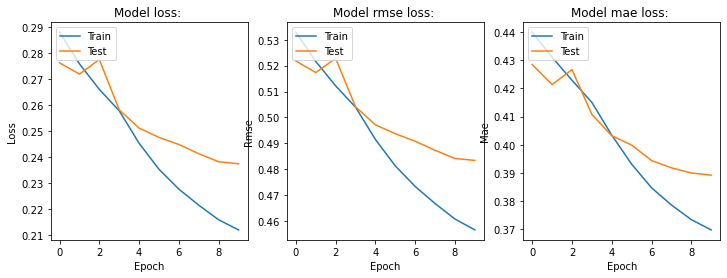

In [210]:
plot_acc_loss(history)

In [211]:
print(history['total_time'])

3899.9558341503143


In [212]:
test_dataset = Word_dataset(test_data,  model1.wv)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)
test_loss, test_rmse_loss, test_mae_loss = test_loop(test_loader,lstm_word_model,device,loss_fn)
print("test loss : " + str(test_loss))
print("test rmse loss : " + str(test_rmse_loss))
print("test mae loss : " + str(test_mae_loss))

test loss : 0.2838934536618129
test rmse loss : 0.5284967396877304
test mae loss : 0.4262329740819338


In [213]:
print(history['train_loss'][-1])
print(history['val_loss'][-1])
print(history['train_rmse'][-1])
print(history['val_rmse'][-1])
print(history['train_mae'][-1])
print(history['val_mae'][-1])

0.21194622
0.23740194404807513
0.4565259695825515
0.4833837679987592
0.36978383067005655
0.3892277255171576


In [214]:
simaese_word.append(history['total_time']/60)
simaese_word.append(history['train_rmse'][-1])
simaese_word.append(history['val_rmse'][-1])
simaese_word.append(test_rmse_loss)
simaese_word.append(history['train_mae'][-1])
simaese_word.append(history['val_mae'][-1])
simaese_word.append(test_mae_loss)

In [215]:
simaese_word

[64.99926390250523,
 0.4565259695825515,
 0.4833837679987592,
 0.5284967396877304,
 0.36978383067005655,
 0.3892277255171576,
 0.4262329740819338]

In [216]:
torch.save(lstm_word_model, 'models/LSTM_Word_Model.pt')

## 2.d Classic ML model with feature extractor

> same as character model

In [217]:
lstm_character_model = torch.load('models/LSTM_Word_Model.pt')
print(list(lstm_character_model.modules()))

[LSTM_Word_Model(
  (similarity): CosineSimilarity()
  (lstm): LSTM(32, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
), CosineSimilarity(), LSTM(32, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True), Linear(in_features=128, out_features=128, bias=True)]


In [218]:
lstm_word_embedding = nn.Sequential(list(lstm_word_model.modules())[2])
print(lstm_word_embedding)

Sequential(
  (0): LSTM(32, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
)


In [219]:
class lstm_word_embedder:
    def __init__(self, lstm_word_embedding):
        self.lstm_word_embedding = lstm_word_embedding
        
    def get_word_embedding(self, description, search):
        description = description.to(device, dtype=torch.float)
        search = search.to(device, dtype=torch.float)

        out_description, _ = self.lstm_word_embedding(description)
        out_search, _  = self.lstm_word_embedding(search)

        description_vector = [x.item() for x in torch.mean(out_description, 0)]
        search_vector = [x.item() for x in torch.mean(out_search, 0)]
        
        return description_vector, search_vector


lstm_word_embedder = lstm_word_embedder(lstm_word_embedding)

In [220]:
X_train = list(map(lambda x: lstm_word_embedder.get_word_embedding(x[0],x[1]), train_dataset))
Y_train = list(map(lambda x: x[2].item() + 2 , train_dataset))

In [221]:
X_val = list(map(lambda x: lstm_word_embedder.get_word_embedding(x[0],x[1]), val_dataset))
Y_val = list(map(lambda x: x[2].item() + 2 , val_dataset))

In [222]:
X_test = list(map(lambda x: lstm_word_embedder.get_word_embedding(x[0],x[1]), test_dataset))
Y_test = list(map(lambda x: x[2].item() + 2 , test_dataset))

In [223]:
len(X_train)

59253

In [224]:
len(Y_train)

59253

In [225]:
train_df = get_df(X_train,Y_train)

In [226]:
val_df = get_df(X_val,Y_val)

In [227]:
test_df = get_df(X_test,Y_test)

In [228]:
train_df

,cosine similarity,Euclidean distance,manhattan distance,minkowski distance,target
0,2.085941,5.233183,38.385220,5.233183,2.00
1,2.158778,5.240858,38.480969,5.240858,2.33
2,2.176606,5.990451,43.660559,5.990451,2.33
3,2.216884,5.632115,40.867057,5.632115,2.67
4,2.187884,6.305274,46.296977,6.305274,3.00
...,...,...,...,...,...
59248,2.246062,3.977183,28.277827,3.977183,3.00
59249,2.218727,6.719334,49.345536,6.719334,2.67
59250,2.219559,6.837307,50.342281,6.837307,3.00
59251,1.909661,6.906864,50.270532,6.906864,2.67


In [229]:
val_df

,cosine similarity,Euclidean distance,manhattan distance,minkowski distance,target
0,2.165478,4.901652,33.340158,4.901652,2.67
1,2.181461,5.918731,43.070094,5.918731,3.00
2,2.253442,6.644456,49.424120,6.644456,3.00
3,2.136241,3.998743,30.094721,3.998743,2.00
4,2.155135,6.826663,50.117718,6.826663,2.67
...,...,...,...,...,...
14809,2.181280,4.002310,27.778840,4.002310,2.67
14810,2.196639,3.387103,25.803129,3.387103,2.33
14811,2.235693,5.223806,37.335367,5.223806,2.33
14812,2.225036,5.384148,39.258380,5.384148,3.00


In [230]:
test_df

,cosine similarity,Euclidean distance,manhattan distance,minkowski distance,target
0,2.042431,6.444273,46.836029,6.444273,2.33
1,1.921433,6.203502,45.347158,6.203502,2.33
2,2.248879,6.257998,46.206486,6.257998,2.67
3,2.228490,5.992203,44.486709,5.992203,2.00
4,2.157134,5.001341,37.331354,5.001341,2.67
...,...,...,...,...,...
112062,2.195159,6.825253,50.178609,6.825253,2.33
112063,2.006547,4.118000,28.770863,4.118000,1.00
112064,2.186645,3.612155,26.674573,3.612155,2.67
112065,2.027147,5.809351,41.836289,5.809351,1.00


In [231]:
y_train = train_df['target']
x_train =train_df.drop('target',axis=1)
y_val = val_df['target']
x_val = val_df.drop('target',axis=1)
y_test = test_df['target']
x_test = test_df.drop('target',axis=1)

## KNN

In [232]:
knn = KNeighborsRegressor()
Knn_params = {
    'weights' : ["uniform","distance"],
    'n_neighbors' : list(range(1, 12, 1))

 }

In [233]:
s_time = time.time()
train_rmse,train_mae,val_rmse,val_mae,test_rmse,test_mae = ML_loop(y_train,x_train,y_val,x_val,y_test,x_test,knn,Knn_params,"K Nearest Neighbors")
end = time.time() - s_time
print("K Nearest Neighbors runtime " + str(end/60) + " minutes")

K Nearest Neighbors
started searching for best hyperpatamters
best paramaters are : {'weights': 'distance', 'n_neighbors': 11}
training score
RMSE : 0.005025965018955241
mae: 8.421514522471437e-05
validation score
RMSE : 0.5114169400090641
mae: 0.4104372913243847
test score
RMSE : 0.5541051093739195
mae: 0.4436415599991505
K Nearest Neighbors runtime 0.13534604708353679 minutes


In [234]:
word_feature_extractor_KNN.append(end/60)
word_feature_extractor_KNN.append(train_rmse)
word_feature_extractor_KNN.append(val_rmse)
word_feature_extractor_KNN.append(test_rmse)
word_feature_extractor_KNN.append(train_mae)
word_feature_extractor_KNN.append(val_mae)
word_feature_extractor_KNN.append(test_mae)


In [235]:
word_feature_extractor_KNN

[0.13534604708353679,
 0.005025965018955241,
 0.5114169400090641,
 0.5541051093739195,
 8.421514522471437e-05,
 0.4104372913243847,
 0.4436415599991505]

## XGBRegressor

In [236]:
xgb1 = xgb.XGBRegressor()
XGB_parameters = {
              'learning_rate': [0.05, 0.10, 0.15],
              'max_depth': [3, 4, 5, 6, 8],
              'n_estimators': [50, 150, 200, 250, 300, 350,400,450,500]}


In [237]:
s_time = time.time()
train_rmse,train_mae,val_rmse,val_mae,test_rmse,test_mae = ML_loop(y_train,x_train,y_val,x_val,y_test,x_test,xgb1,XGB_parameters,"XGB")
end = time.time() - s_time
print("XGB runtime " + str(end/60) + " minutes")

XGB
started searching for best hyperpatamters
best paramaters are : {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1}
training score
RMSE : 0.44557621399531083
mae: 0.35837902795183463
validation score
RMSE : 0.49100877102885804
mae: 0.3959768394324982
test score
RMSE : 0.5356313058309072
mae: 0.4305137314241137
XGB runtime 2.1060641487439473 minutes


In [238]:
word_feature_extractor_XGB.append(end/60)
word_feature_extractor_XGB.append(train_rmse)
word_feature_extractor_XGB.append(val_rmse)
word_feature_extractor_XGB.append(test_rmse)
word_feature_extractor_XGB.append(train_mae)
word_feature_extractor_XGB.append(val_mae)
word_feature_extractor_XGB.append(test_mae)


In [239]:
word_feature_extractor_XGB

[2.1060641487439473,
 0.44557621399531083,
 0.49100877102885804,
 0.5356313058309072,
 0.35837902795183463,
 0.3959768394324982,
 0.4305137314241137]

In [242]:
results = {'simaese_char': simaese_char,'naive_benchmark':naive_benchmark,'char_feature_extractor_KNN':char_feature_extractor_KNN,'char_feature_extractor_XGB':char_feature_extractor_XGB,'simaese_word':simaese_word,'word_feature_extractor_KNN':word_feature_extractor_KNN,'word_feature_extractor_XGB':word_feature_extractor_XGB}


In [243]:
table = pd.DataFrame.from_dict(results, orient='index')

In [244]:
table

,0,1,2,3,4,5,6
simaese_char,53.938973,0.525479,0.524640,0.528291,0.433532,0.432484,0.435381
naive_benchmark,0.929184,0.587146,0.583973,0.588534,0.473375,0.470216,0.473584
char_feature_extractor_KNN,0.111647,0.016072,0.550279,0.558574,0.000761,0.447686,0.454578
char_feature_extractor_XGB,1.160715,0.523946,0.527451,0.531795,0.429204,0.432676,0.435429
simaese_word,64.999264,0.456526,0.483384,0.528497,0.369784,0.389228,0.426233
word_feature_extractor_KNN,0.135346,0.005026,0.511417,0.554105,0.000084,0.410437,0.443642
word_feature_extractor_XGB,2.106064,0.445576,0.491009,0.535631,0.358379,0.395977,0.430514


In [245]:
table.columns = ['Runtime', 'train_rmse', 'val_rmse', 'test_rmse', 'train_mae','val_mae','test_mae']

In [246]:
table

,Runtime,train_rmse,val_rmse,test_rmse,train_mae,val_mae,test_mae
simaese_char,53.938973,0.525479,0.524640,0.528291,0.433532,0.432484,0.435381
naive_benchmark,0.929184,0.587146,0.583973,0.588534,0.473375,0.470216,0.473584
char_feature_extractor_KNN,0.111647,0.016072,0.550279,0.558574,0.000761,0.447686,0.454578
char_feature_extractor_XGB,1.160715,0.523946,0.527451,0.531795,0.429204,0.432676,0.435429
simaese_word,64.999264,0.456526,0.483384,0.528497,0.369784,0.389228,0.426233
word_feature_extractor_KNN,0.135346,0.005026,0.511417,0.554105,0.000084,0.410437,0.443642
word_feature_extractor_XGB,2.106064,0.445576,0.491009,0.535631,0.358379,0.395977,0.430514
